In [1]:
import pickle, os
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch

from veloproj import *
from veloproj.model import leastsq_pt
from IPython import display
from matplotlib import pyplot as plt

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr',  '1e-5',
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--data-dir', '/data/groups/yhhuang/cqiao/Melania/adata_umap_pca.h5',
                               '--model-name', 'Melania_Erythroid_mouse_model.cpt',
                               '--exp-name', 'CohAE_Melania_Erythroid_mouse',
                               '--device', 'cuda:0',
                               '--gumbsoft_tau', '1',
                               '--nb_g_src', "SU",
                               '--n_raw_gene', '2000',
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("Erythroid1", "Erythroid2"), ('Erythroid2', "Erythroid3")]
k_cluster = "celltype"
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
        
    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, xyids, device)
    return tensor_s, tensor_u, tensor_x  

In [6]:
par_path = "/data/users/cqiao/notebooks/projects/PaperRev/VeloRep2/notebooks/Melania_mouse/"
fast_data_path = "data.h5ad"
if fast_data_path in os.listdir(par_path):
    adata = scanpy.read_h5ad(os.path.join(par_path, fast_data_path))
else:
    adata = scanpy.read_h5ad(args.data_dir)
    sel = np.zeros(adata.n_obs, dtype=np.bool)
    sel = sel | (adata.obs.celltype == "Erythroid1").values | (adata.obs.celltype == "Erythroid2").values | (adata.obs.celltype == "Erythroid3").values
    sel = sel | (adata.obs.celltype == "Blood progenitors 1").values | sel | (adata.obs.celltype == "Blood progenitors 2").values
    adata = adata[sel]
    scv.utils.show_proportions(adata)
    scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
    scv.tl.velocity_graph(adata, vkey='stc_velocity')
    scv.tl.velocity_confidence(adata, vkey='stc_velocity')
    
print(adata)



AnnData object with n_obs × n_vars = 9815 × 2000
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'stc_velocity_self_transition', 'stc_velocity_length', 'stc_velocity_confidence', 'stc_velocity_confidence_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'stc_velocity_gamma', 'stc_velocity_r2', 'stc_velocity_genes'
    uns: 'celltype_colors', 'neighbors', 'stc_velocity_graph', 'stc_velocity_graph_neg', 'stc_velocity_params'
    obsm: 'X_pca', 'X_

saving figure to file ./figures/scvelo_Melania_Erythroid_mouse_stochastical.png


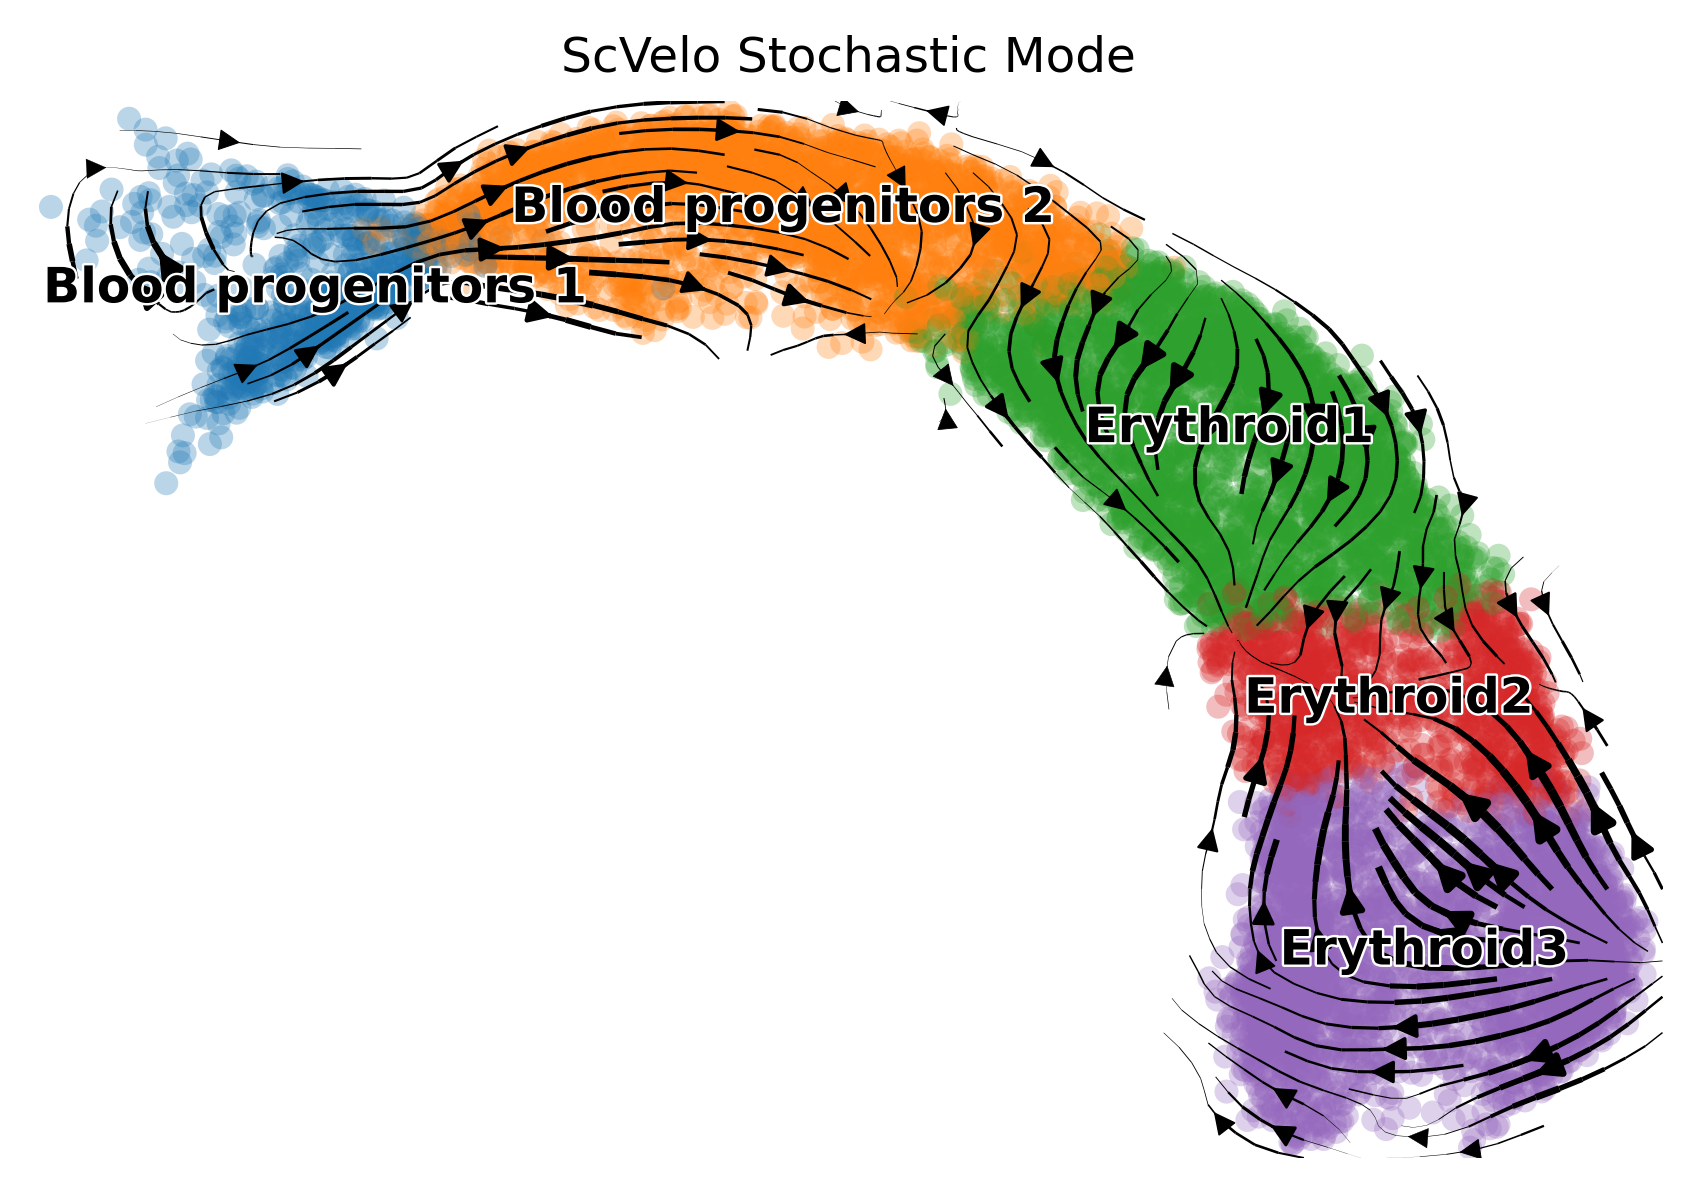

# Cross-Boundary Transition Score (A->B)
{('Erythroid1', 'Erythroid2'): 0.17114995, ('Erythroid2', 'Erythroid3'): 0.09341168}
Total Mean: 0.13228081166744232
# Cross-Boundary Velocity Coherence (A->B)
{('Erythroid1', 'Erythroid2'): 0.6864096, ('Erythroid2', 'Erythroid3'): 0.73946804}
Total Mean: 0.7129387855529785
# Cross-Boundary Direction Correctness (A->B)
{('Erythroid1', 'Erythroid2'): 0.35671440778567015, ('Erythroid2', 'Erythroid3'): -0.5571900059139028}
Total Mean: -0.10023779906411631
# In-cluster Coherence
{'Blood progenitors 1': 0.7551233, 'Blood progenitors 2': 0.7151811, 'Erythroid1': 0.70970446, 'Erythroid2': 0.7345957, 'Erythroid3': 0.8732634}
Total Mean: 0.7575736045837402
# In-cluster Confidence
{'Blood progenitors 1': 0.7300548396083746, 'Blood progenitors 2': 0.6358000902958937, 'Erythroid1': 0.7121040044950506, 'Erythroid2': 0.6815228624434411, 'Erythroid3': 0.9347134761548193}
Total Mean: 0.7388390545995158


In [7]:
scv.pl.velocity_embedding_stream(adata, vkey="stc_velocity", basis='X_umap', color=[k_cluster],dpi=350,
                                title='ScVelo Stochastic Mode', save="Melania_Erythroid_mouse_stochastical.png")
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity", x_emb="X_umap")

computing neighbors
    finished (0:00:20) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Train Epoch: 100/20000 	Loss: 407.297699
Train Epoch: 200/20000 	Loss: 384.708923
Train Epoch: 300/20000 	Loss: 373.710907
Train Epoch: 400/20000 	Loss: 363.234833
Train Epoch: 500/20000 	Loss: 352.492462
Train Epoch: 600/20000 	Loss: 359.221741
Train Epoch: 700/20000 	Loss: 345.996521
Train Epoch: 800/20000 	Loss: 339.819244
Train Epoch: 900/20000 	Loss: 334.032990
Train Epoch: 1000/20000 	Loss: 390.894775
Train Epoch: 1100/20000 	Loss: 330.673248
Train Epoch: 1200/20000 	Loss: 324.984344
Train Epoch: 1300/20000 	Loss: 407.536469
Train Epoch: 1400/20000 	Loss: 408.894989
Train Epoch: 1500/20000 	Loss: 321.152557
Train Epoch: 1600/20000 	Loss: 318.151825
Train Epoch: 1700/20000 	Loss: 315.417084
Train Epoch: 1800/2

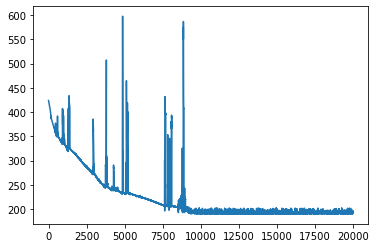

In [8]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:05) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph (using 1/40 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:26) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:08) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_Melania_Erythroid_mouse_pojection.png


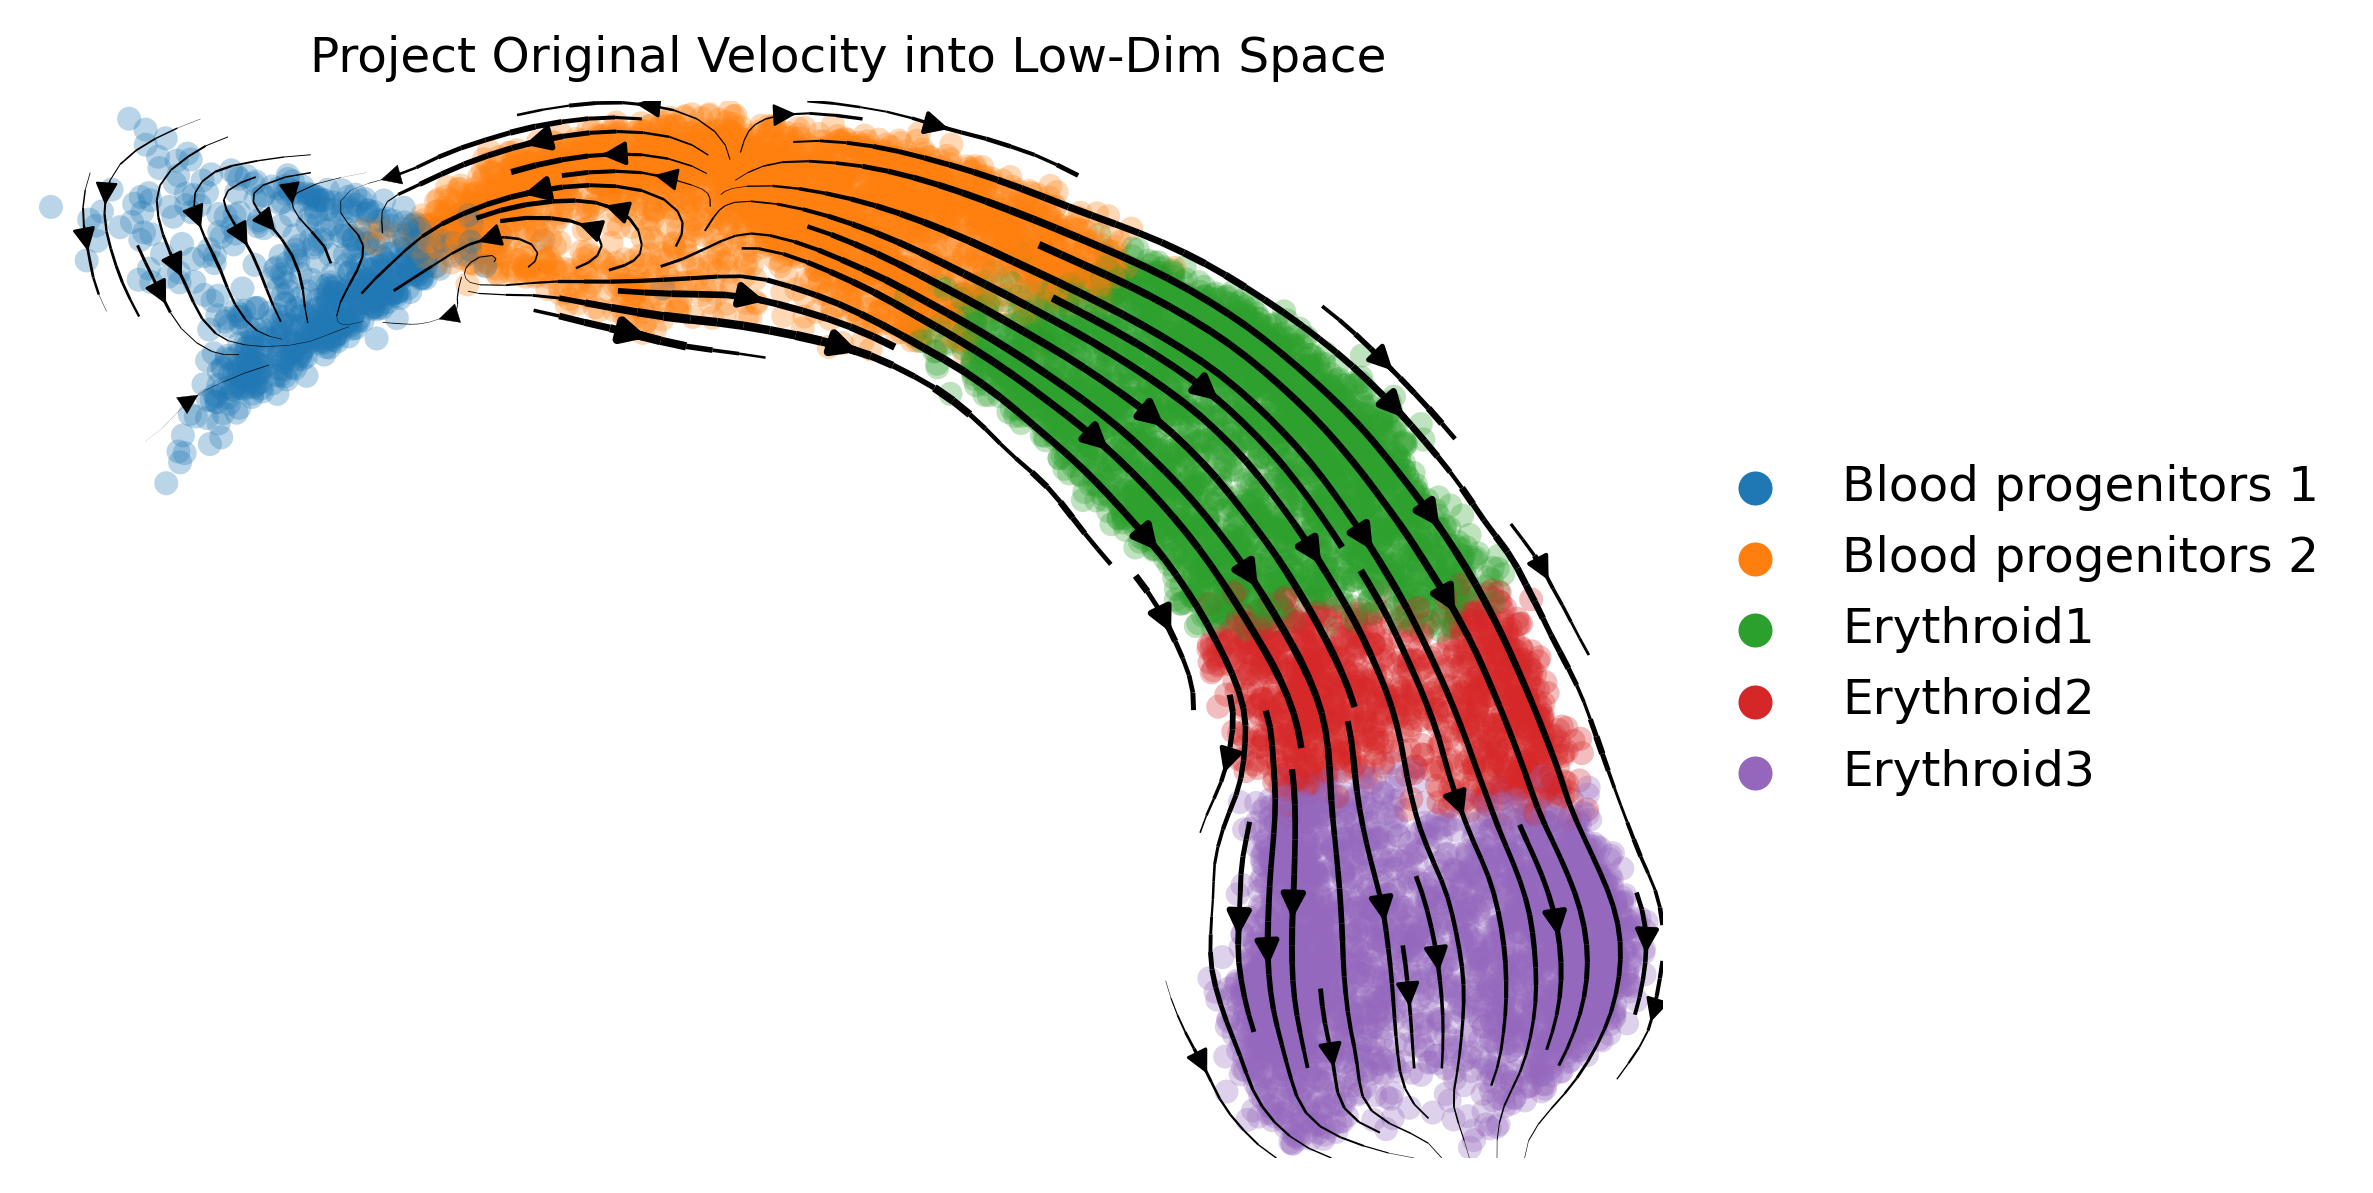

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Erythroid1', 'Erythroid2'): 0.7656465, ('Erythroid2', 'Erythroid3'): 0.7599802}
Total Mean: 0.7628133296966553
# Cross-Boundary Velocity Coherence (A->B)
{('Erythroid1', 'Erythroid2'): 0.9999224, ('Erythroid2', 'Erythroid3'): 0.999926}
Total Mean: 0.9999241828918457
# Cross-Boundary Direction Correctness (A->B)
{('Erythroid1', 'Erythroid2'): 0.8517188463568378, ('Erythroid2', 'Erythroid3'): 0.8110304256597118}
Total Mean: 0.8313746360082748
# In-cluster Coherence
{'Blood progenitors 1': 0.9999275, 'Blood progenitors 2': 0.99992824, 'Erythroid1': 0.9999309, 'Erythroid2': 0.999934, 'Erythroid3': 0.99992865}
Total Mean: 0.9999297857284546
# In-cluster Confidence
{'Blood progenitors 1': 0.9999021605542154, 'Blood progenitors 2': 0.99990572430254, 'Erythroid1': 0.9999094563932214, 'Erythroid2': 0.99

In [9]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis="X")
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, legend_loc='right_margin', vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Project Original Velocity into Low-Dim Space",
                                    dpi=350,
                                    save='Melania_Erythroid_mouse_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity", x_emb="X_umap")
    
    
exp(adata, exp_metrics)

In [10]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)